In [1]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

In [2]:
# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="USD",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data

In [3]:
def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

In [4]:
# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H

In [5]:
def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H

In [6]:
def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)

In [7]:
def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [8]:
coin_sym_list = 'BTC ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':'2017']  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

In [9]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,BTC,ETH,DASH,LTC
time,,,,
2014-01-01,815.94,NaN,NaN,24.77
2014-01-02,856.91,NaN,NaN,26.60
2014-01-03,884.26,NaN,NaN,25.49
2014-01-04,924.69,NaN,NaN,24.05
2014-01-05,1014.74,NaN,NaN,26.01
,BTC,ETH,DASH,LTC
time,,,,
2017-12-27,15416.64,739.94,1133.36,264.07
2017-12-28,14398.70,716.69,1103.06,249.86


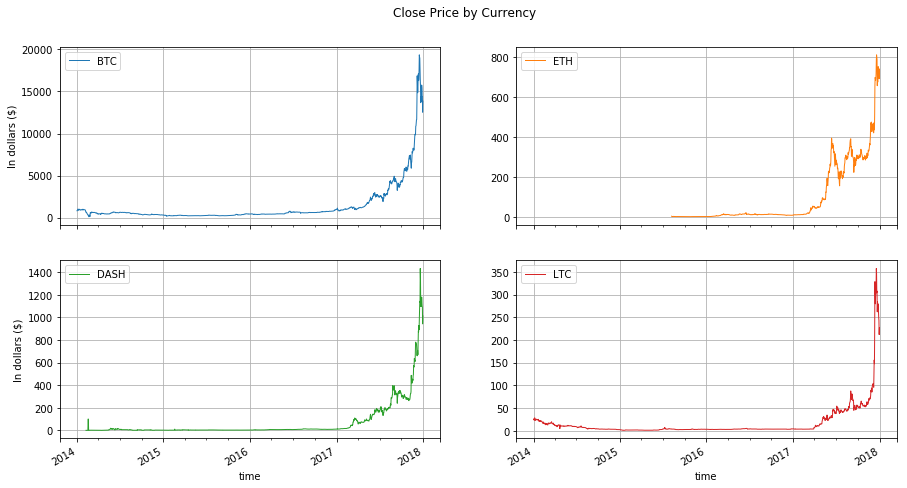

In [10]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [11]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in hurst_rs
/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
BTC,0.707679,0.574953,NaN
ETH,0.595606,0.615792,NaN
DASH,0.426228,0.518237,NaN
LTC,0.626129,0.583684,NaN


In [12]:
# the same methodology as shown in the paper.
roll_days = 400
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [13]:
roll_hurst[::10].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-11-21  0.481489  0.582151  0.300715  0.651759  0.499761  0.682960   
2017-12-01  0.524827  0.577722  0.298599  0.658343  0.520340  0.690913   
2017-12-11  0.859852  0.634463  0.379143  0.612409  0.475629  0.698640   
2017-12-21  0.951275  0.624665  0.084307  0.593045  0.739241  0.693251   
2017-12-31  0.710996  0.607865  0.403582  0.574600  0.597764  0.708033   

                 LTC            
                DSOD        RS  
time                            
2017-11-21  0.507280  0.622473  
2017-12-01  0.487779  0.607000  
2017-12-11  0.150825  0.619119  
2017-12-21  0.777695  0.599102  
2017-12-31  0.633783  0.564455

In [14]:
roll_hurst[::10].mean()

BTC   DSOD    0.562069
      RS      0.587629
DASH  DSOD    0.348060
      RS      0.502795
ETH   DSOD    0.519302
      RS      0.616097
LTC   DSOD    0.494971
      RS      0.568760
dtype: float64

In [15]:
roll_hurst[::10].median()

BTC   DSOD    0.562083
      RS      0.592432
DASH  DSOD    0.446686
      RS      0.476602
ETH   DSOD    0.502365
      RS      0.609199
LTC   DSOD    0.499061
      RS      0.567570
dtype: float64

In [16]:
roll_hurst[::10].mean(level=0, axis=1);

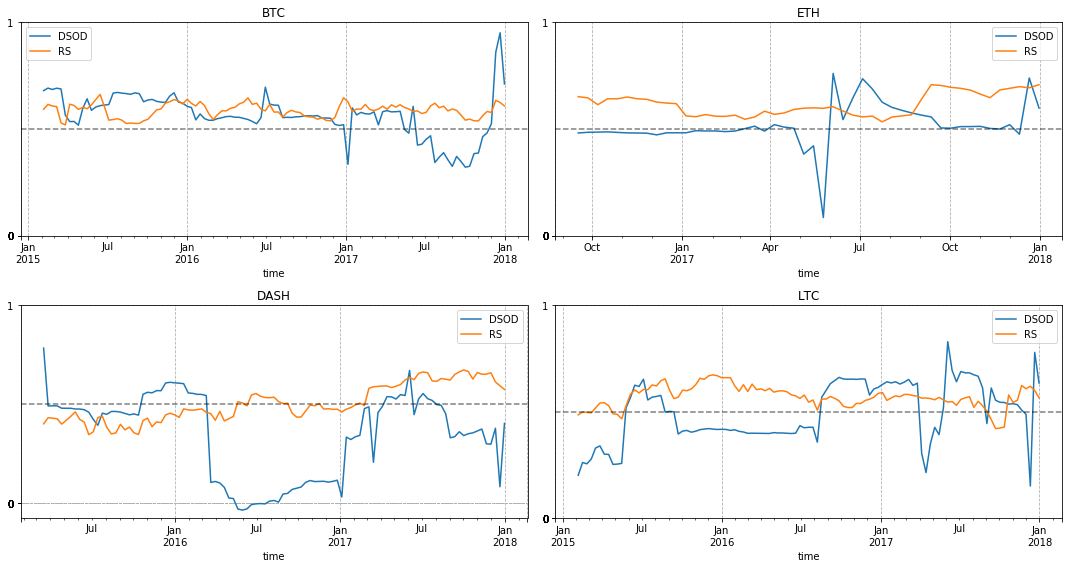

In [17]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [18]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-12-27  0.886659  0.615829  0.394017  0.584679  0.673910  0.705215   
2017-12-28  0.875818  0.615200  0.394962  0.586238  0.666985  0.708686   
2017-12-29  0.865202  0.615642  0.394525  0.585670  0.659570  0.709817   
2017-12-30  0.849912  0.615099  0.409883  0.584093  0.650321  0.711082   
2017-12-31  0.825884  0.613419  0.441811  0.582249  0.636174  0.712560   

                 LTC            
                DSOD        RS  
time                            
2017-12-27  0.716126  0.593619  
2017-12-28  0.705464  0.590395  
2017-12-29  0.699129  0.589065  
2017-12-30  0.686592  0.587520  
2017-12-31  0.672201  0.584055

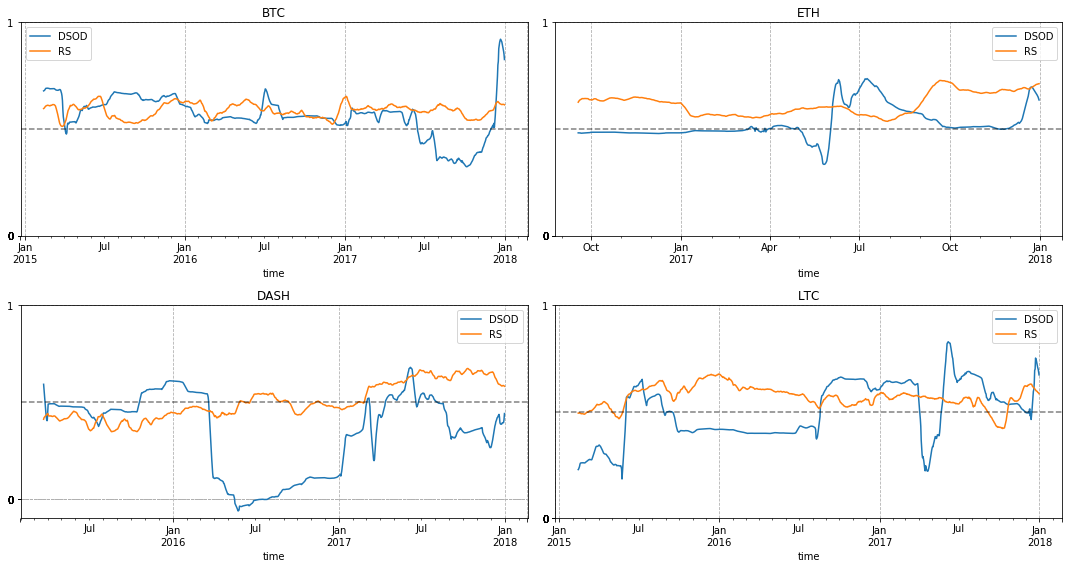

In [19]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [20]:
roll_hurst[::20].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-10-12  0.325111  0.546414  0.351424  0.664624  0.511259  0.690791   
2017-11-01  0.387005  0.537862  0.365088  0.659996  0.512481  0.663810   
2017-11-21  0.481489  0.582151  0.300715  0.651759  0.499761  0.682960   
2017-12-11  0.859852  0.634463  0.379143  0.612409  0.475629  0.698640   
2017-12-31  0.710996  0.607865  0.403582  0.574600  0.597764  0.708033   

                 LTC            
                DSOD        RS  
time                            
2017-10-12  0.542754  0.427307  
2017-11-01  0.537179  0.543649  
2017-11-21  0.507280  0.622473  
2017-12-11  0.150825  0.619119  
2017-12-31  0.633783  0.564455

In [21]:
roll_hurst[::20].mean()

BTC   DSOD    0.559742
      RS      0.589076
DASH  DSOD    0.354780
      RS      0.500216
ETH   DSOD    0.500167
      RS      0.617078
LTC   DSOD    0.486908
      RS      0.569917
dtype: float64

In [22]:
roll_hurst[::20].median()

BTC   DSOD    0.563648
      RS      0.593302
DASH  DSOD    0.448530
      RS      0.474946
ETH   DSOD    0.495222
      RS      0.609671
LTC   DSOD    0.498343
      RS      0.569787
dtype: float64

In [23]:
roll_hurst[::20].mean(level=0, axis=1);

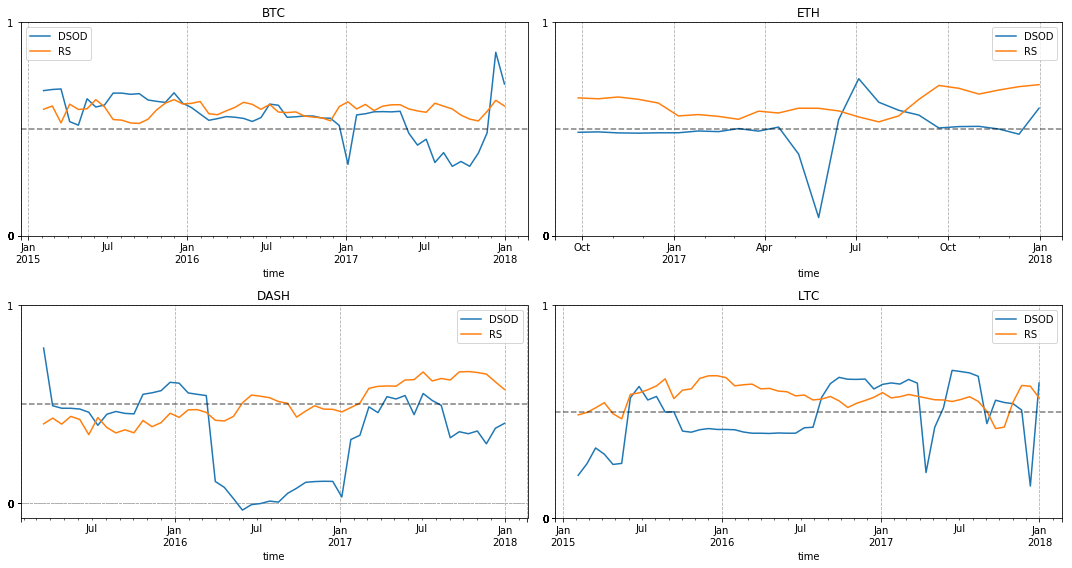

In [24]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [25]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-12-27  0.852123  0.621382  0.411206  0.590364  0.638428  0.699258   
2017-12-28  0.876413  0.620119  0.414061  0.589786  0.643931  0.699764   
2017-12-29  0.878776  0.618879  0.415905  0.588999  0.648204  0.699176   
2017-12-30  0.878076  0.617219  0.417013  0.588247  0.652381  0.699513   
2017-12-31  0.870633  0.615889  0.418235  0.586356  0.658488  0.699983   

                 LTC            
                DSOD        RS  
time                            
2017-12-27  0.639236  0.605016  
2017-12-28  0.650056  0.602724  
2017-12-29  0.651154  0.600649  
2017-12-30  0.658732  0.598276  
2017-12-31  0.682880  0.595543

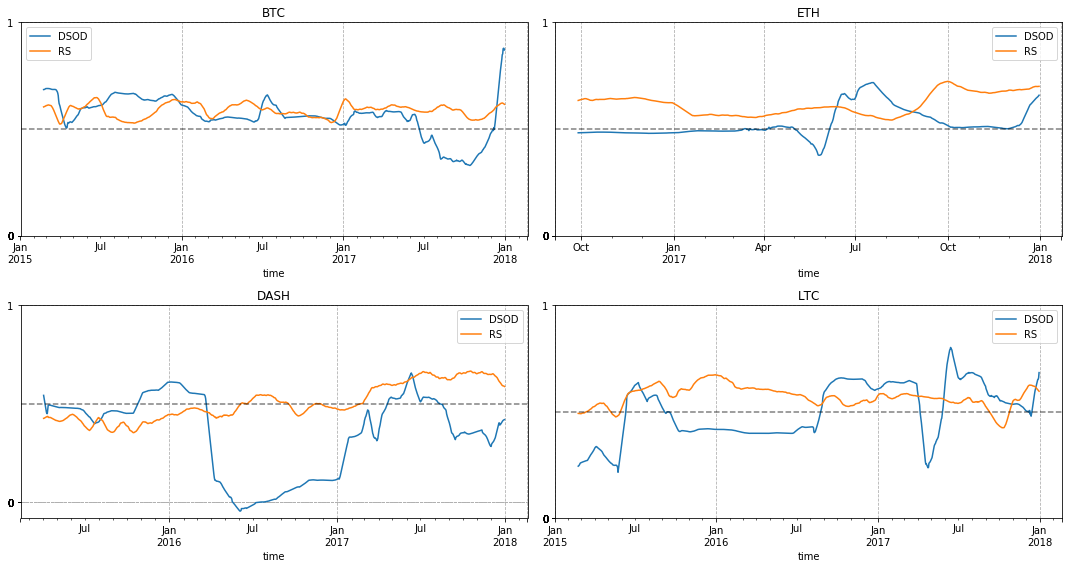

In [26]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [27]:
roll_hurst[::30].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-08-13  0.389038  0.607165  0.494546  0.629667  0.587672  0.561691   
2017-09-12  0.371434  0.587015  0.336543  0.650002  0.556591  0.707621   
2017-10-12  0.325111  0.546414  0.351424  0.664624  0.511259  0.690791   
2017-11-11  0.464141  0.562097  0.374970  0.651115  0.502755  0.646985   
2017-12-11  0.859852  0.634463  0.379143  0.612409  0.475629  0.698640   

                 LTC            
                DSOD        RS  
time                            
2017-08-13  0.665774  0.548206  
2017-09-12  0.610801  0.462918  
2017-10-12  0.542754  0.427307  
2017-11-11  0.532850  0.552528  
2017-12-11  0.150825  0.619119

In [28]:
roll_hurst[::30].mean()

BTC   DSOD    0.558570
      RS      0.587496
DASH  DSOD    0.341076
      RS      0.505226
ETH   DSOD    0.513736
      RS      0.615982
LTC   DSOD    0.486170
      RS      0.569178
dtype: float64

In [29]:
roll_hurst[::30].median()

BTC   DSOD    0.555266
      RS      0.591767
DASH  DSOD    0.412914
      RS      0.475832
ETH   DSOD    0.497456
      RS      0.610467
LTC   DSOD    0.497625
      RS      0.566896
dtype: float64

In [30]:
roll_hurst[::30].mean(level=0, axis=1);

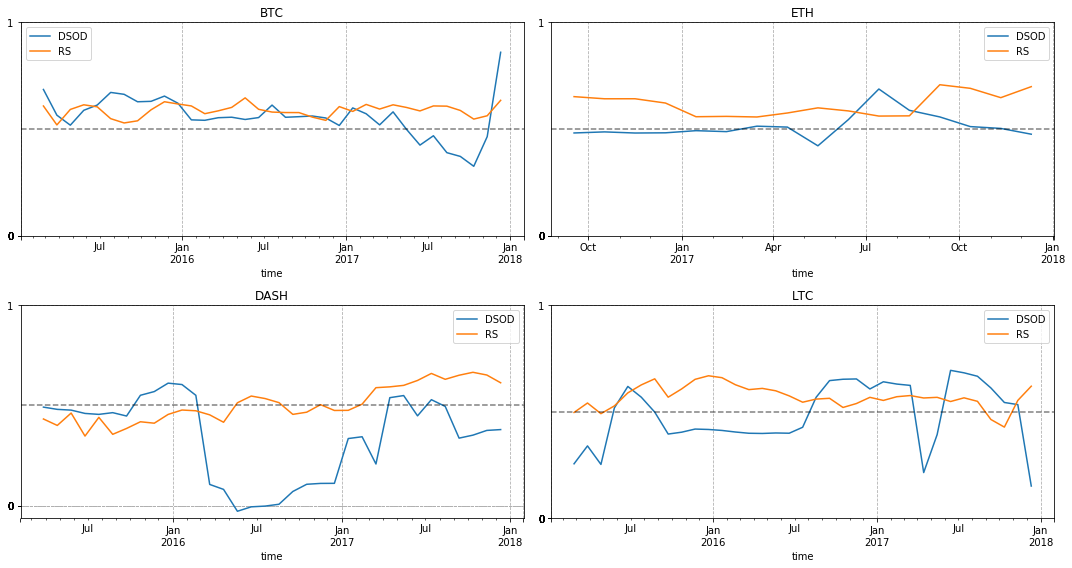

In [31]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::30].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [32]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-12-27  0.743667  0.612496  0.385348  0.609915  0.599146  0.692704   
2017-12-28  0.753780  0.613485  0.392066  0.607601  0.603722  0.693980   
2017-12-29  0.763779  0.614342  0.399202  0.604586  0.607930  0.694510   
2017-12-30  0.772540  0.615197  0.404063  0.601940  0.611983  0.695187   
2017-12-31  0.778746  0.616201  0.407563  0.599149  0.614564  0.695758   

                 LTC            
                DSOD        RS  
time                            
2017-12-27  0.591958  0.611537  
2017-12-28  0.597806  0.610354  
2017-12-29  0.604169  0.609240  
2017-12-30  0.610070  0.608221  
2017-12-31  0.614937  0.606803

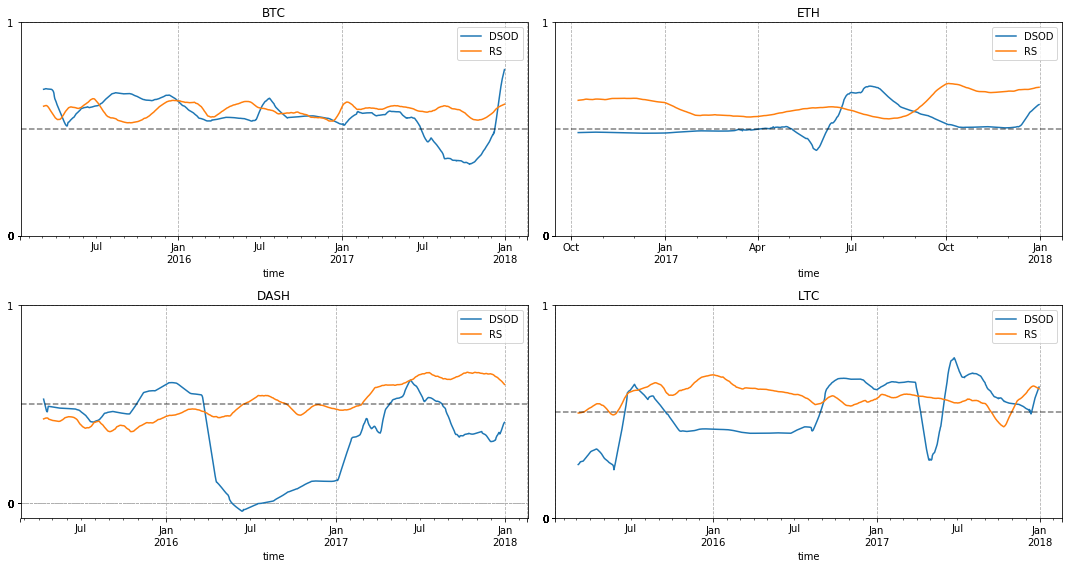

In [33]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [34]:
roll_hurst[::50].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-06-04  0.606241  0.583234  0.670461  0.635065  0.760835  0.604307   
2017-07-24  0.342793  0.620981  0.519261  0.617242  0.625613  0.533399   
2017-09-12  0.371434  0.587015  0.336543  0.650002  0.556591  0.707621   
2017-11-01  0.387005  0.537862  0.365088  0.659996  0.512481  0.663810   
2017-12-21  0.951275  0.624665  0.084307  0.593045  0.739241  0.693251   

                 LTC            
                DSOD        RS  
time                            
2017-06-04  0.828098  0.544588  
2017-07-24  0.681601  0.569767  
2017-09-12  0.610801  0.462918  
2017-11-01  0.537179  0.543649  
2017-12-21  0.777695  0.599102

In [35]:
roll_hurst[::50].mean()

BTC   DSOD    0.567369
      RS      0.582347
DASH  DSOD    0.346060
      RS      0.496521
ETH   DSOD    0.564227
      RS      0.619157
LTC   DSOD    0.498883
      RS      0.568937
dtype: float64

In [36]:
roll_hurst[::50].median()

BTC   DSOD    0.563008
      RS      0.589392
DASH  DSOD    0.445037
      RS      0.476602
ETH   DSOD    0.510720
      RS      0.623086
LTC   DSOD    0.459035
      RS      0.571753
dtype: float64

In [37]:
roll_hurst[::50].mean(level=0, axis=1);

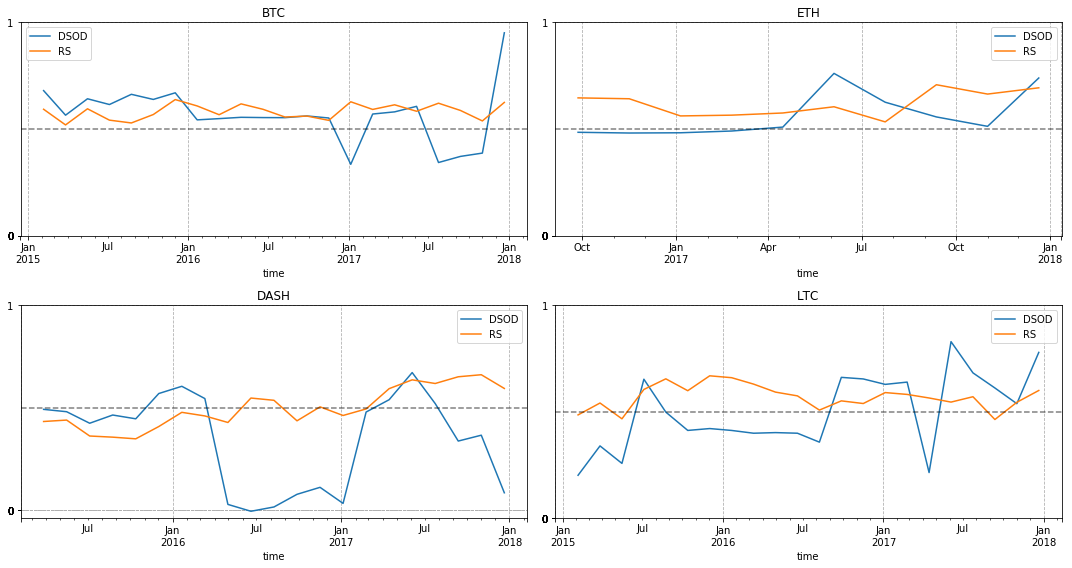

In [38]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [39]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-12-27  0.631595  0.596991  0.352094  0.624901  0.560179  0.686505   
2017-12-28  0.639714  0.598101  0.353863  0.623730  0.562848  0.687588   
2017-12-29  0.648523  0.599169  0.355664  0.622034  0.565324  0.688304   
2017-12-30  0.655504  0.600160  0.357138  0.620134  0.567634  0.689210   
2017-12-31  0.660441  0.601076  0.357710  0.618603  0.569534  0.690431   

                 LTC            
                DSOD        RS  
time                            
2017-12-27  0.561187  0.602356  
2017-12-28  0.563773  0.602832  
2017-12-29  0.566368  0.603581  
2017-12-30  0.568772  0.604167  
2017-12-31  0.570791  0.604405

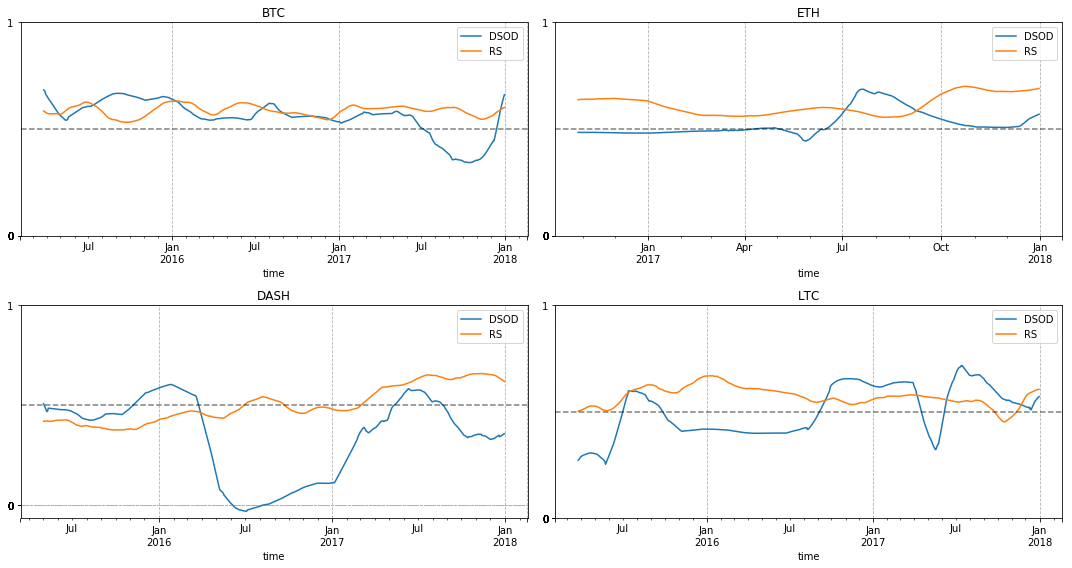

In [40]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
